# Práctica 5 de IA

## 1. Construcción de clasificadores en bases de datos sintéticas

In [2]:
# Esta primera parte está adaptada de:
# http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [4]:
# data preparation
simple = make_blobs(n_samples=500, n_features=2,
                    centers=[[0,0], [2.5,2.5]],
                    random_state=1)
X,y = make_blobs(n_samples=500, n_features=2,
                 centers=[[0,0], [5,1]],
                 random_state=1)
X = X*np.matrix([[1,-2],[-20,10]])
linearly_separable=(X,y)

datasets = [simple,
            linearly_separable,
            make_moons(noise=0.1, random_state=0, n_samples=500),
            make_circles(noise=0.1, factor=0.5, random_state=1,
                         n_samples=500)
           ]

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


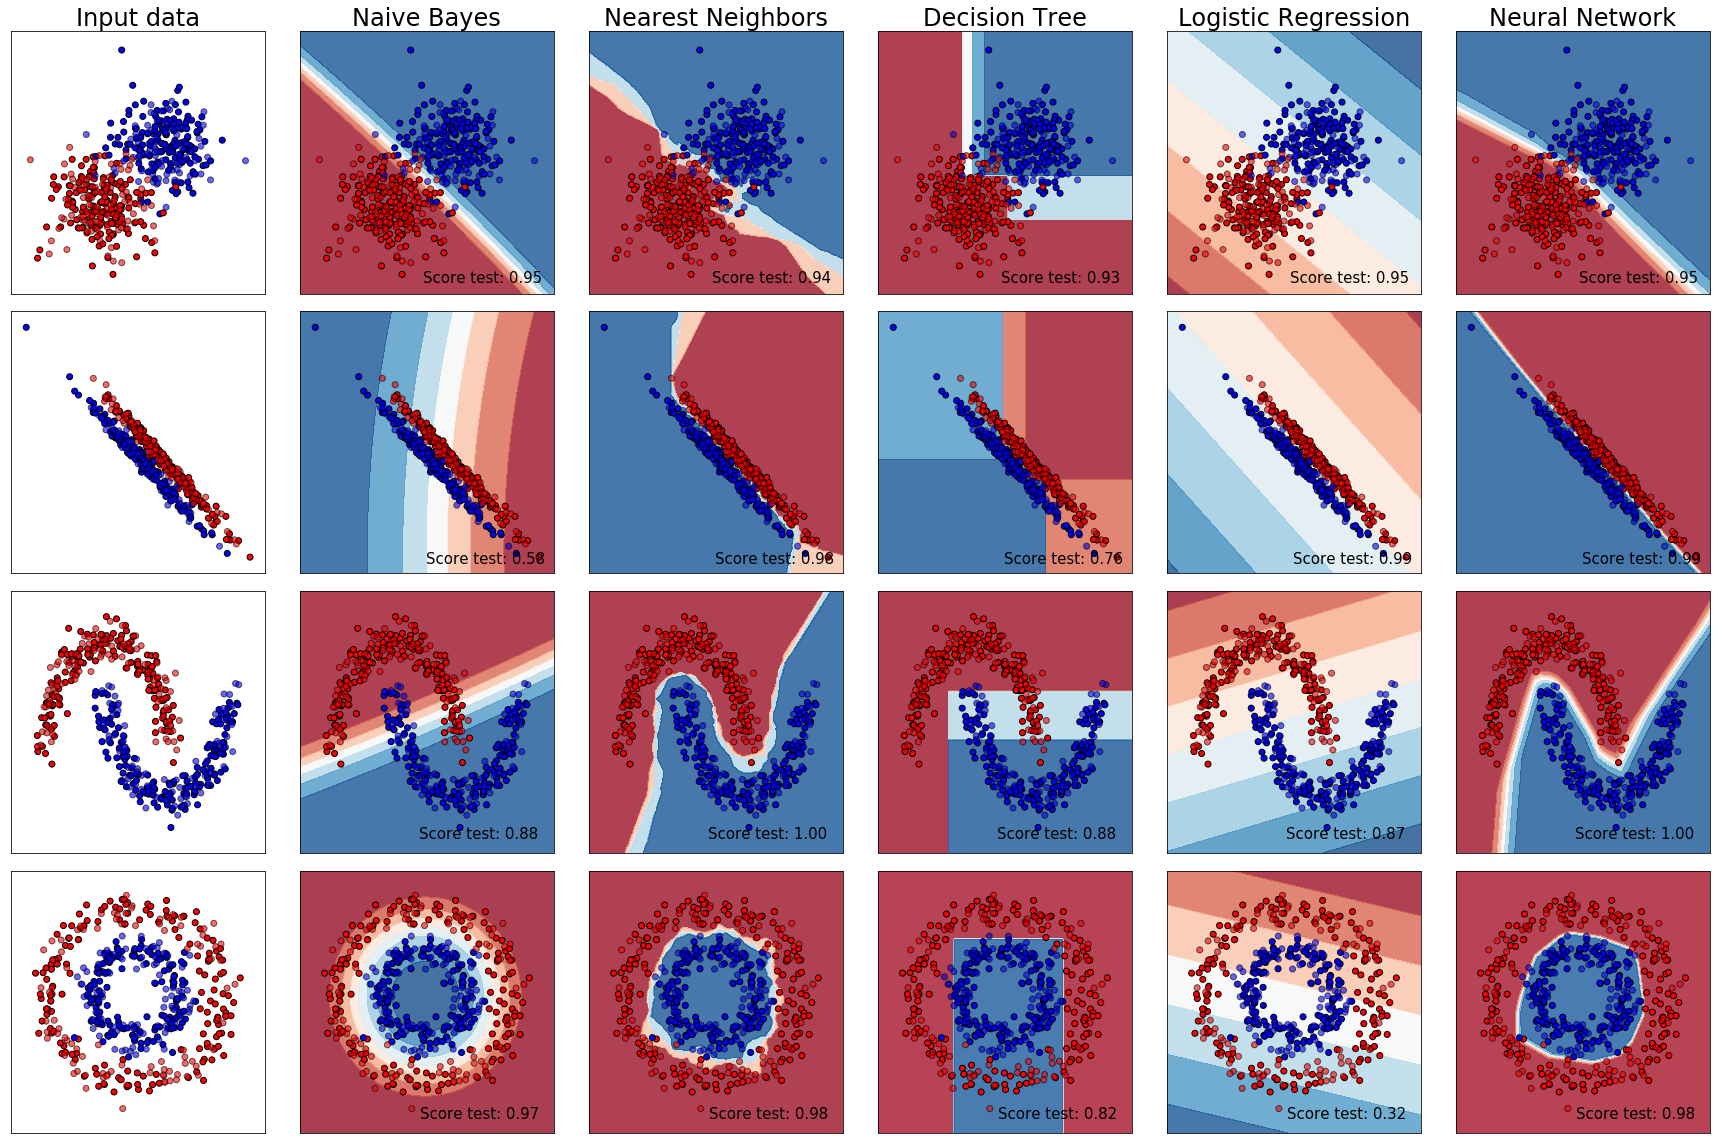

In [33]:
classifiers = [("Naive Bayes", GaussianNB()),
               ("Nearest Neighbors",
                KNeighborsClassifier(n_neighbors=3)), # número de vecinos
               ("Decision Tree",
                DecisionTreeClassifier(criterion='entropy',
                                       max_depth=3)), # profundidad máxima del árbol
               ("Logistic Regression",
                LogisticRegression(C=1e10,solver='lbfgs')), # C: cuanto más alto menos regularización 
               ("Neural Network",
                MLPClassifier(hidden_layer_sizes=(15, 15, 15),
                              max_iter=1000,
                              alpha=0))]

from p5_IA_aux import plot_classifiers

plot_classifiers(classifiers, datasets)

In [6]:
# Listado de los parámetros de los diferentes clasificadores
for name, clf in classifiers:
    print(clf)

GaussianNB(priors=None, var_smoothing=1e-09)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 1

**Prueba a cambiar los siguientes parámetros y observa las consecuencias en la frontera de clasificación construida:**

* Número de vecinos en k-nn. ¿Por qué siempre debe ser impar cuando hay dos clases?
* Profundidad máxima de los árboles de decisión.
* Número de neuronas en la red neuronal y máximo número de épocas de entrenamiento. ** Nota: ** (50,) indica una única capa oculta con 50 neuronas. (50,10,) indica dos capas ocultas con 50 y 10 neuronas respectivamente. (50,10,20,) indica tres capas ocultas con 50, 10 y 20 neuronas respectivamente, etc.

**1.1)** Porque en caso de haya $k/2$ vecninos de una clase y $k/2$ de la otra, la clase predicha para ese ejemplo de entrenamiento será escogido al azar.

**1.2)** 

max_depth=1 -> Se puede ver fácilmente que hay underfitting. Necesitamos más profundidad.

max_depth=2 -> Mejora un poco pero con muchos sesgos.

max_depth=3 -> La peor precisión es del $76\%$ y la mejor del $93\%$.

max_depth=4 -> Ya comienza a detectarse overfitting. Existen ciertas zonas predichas de una clase debido a que intenta clasificar correctamente un ejemplo en concreto, perdiendo generalidad.

**1.3)**
Para hidden=(1,) y hidden=(1,1,) con 1000 iteraciones se puede ver que el modelo tiene underfitting. 3 de 4 conjuntos de entrenamiento no se clasfican correctamente.

Para hidden=(3,) con 1000 iteraciones, en 3 de 4 conjuntos de entrenamiento obtenemos una buena precisión ($> 86\%$), en el otro tiene peores resultados, pero decentes ($> 74\%$).

Para hidden=(3,) con 100 iteraciones no obtenemos nada útil. Es literalmente basura.

Para hidden=(5,5,) y hidden=(7,) con 1000 iteraciones obtenemos mejores resultados. Son bastante decentes, con una precisión por encima del $95\%$.

En todos las pruebas anteriores el software nos advertía que se habían alcanzado el número máximo de iteraciones pero sin alcanzar la optimización máxima esperada.

Con hidden=(20,20,) y hidden=(50,) y 1000 iteraciones ya obtenemos la misma precisión que las dos últimas pruebas, pero esta vez no nos advierte de que se hayan alcanzado las iteraciones máximas.

Con hidden=(100,100,100,) sí parece empezar a haber overfitting en el primer conjunto de entrenamiento.


# 2. Construcción de un clasificador en una base de datos real

In [62]:
df = pd.read_csv("pima.csv", header=0, sep=',')
print(df.shape)
df.head(5)

(768, 9)


,numPregnant,glucose,bloodPress,skinThick,insulin,massIndex,pedigree,age,class
0,6,148,72,35,0,33.6,0.627,50,yes
1,1,85,66,29,0,26.6,0.351,31,no
2,8,183,64,0,0,23.3,0.672,32,yes
3,1,89,66,23,94,28.1,0.167,21,no
4,0,137,40,35,168,43.1,2.288,33,yes


**El objetivo es predecir si una paciente tiene o no diabetes a partir de los valores de otras variables. La variable target es "class".**

* ** Pregnancies: ** Number of times pregnant
* ** Glucose: ** Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* ** BloodPressure: ** Diastolic blood pressure (mm Hg)
* ** SkinThickness: ** Triceps skin fold thickness (mm)
* ** Insulin: ** 2-Hour serum insulin (mu U/ml)
* ** BMI: ** Body mass index (weight in kg/(height in m)^2)
* ** DiabetesPedigreeFunction: ** Diabetes pedigree function
* ** Age: ** Age (years)
* ** Class: ** Class variable ("yes" / "no")

In [63]:
nombres_atrs = list(df.columns)
nombres_atrs.remove('class')
print(nombres_atrs)
X = df[nombres_atrs].values
y = df['class'].values

['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']


**Estadísticos básicos de cada atributo:**

In [64]:
df.describe()

,numPregnant,glucose,bloodPress,skinThick,insulin,massIndex,pedigree,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


**Histogramas suavizados de cada atributo en cada clase. El color indica la clase ("yes"/"no"):**

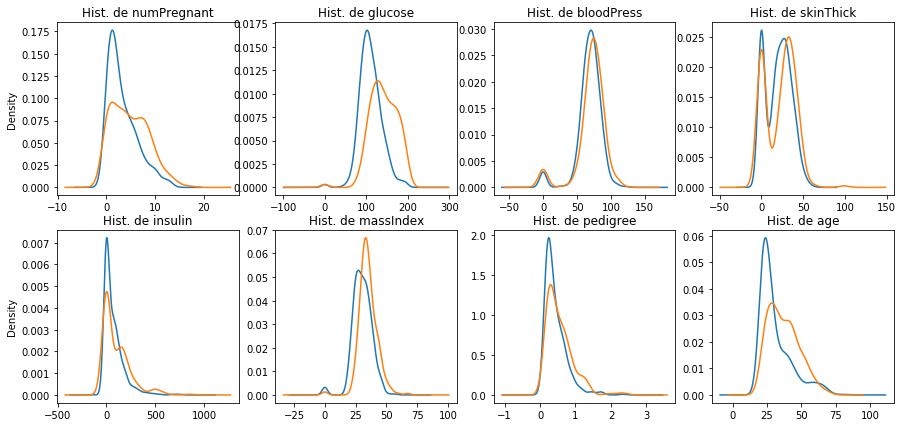

In [65]:
plt.figure(figsize=(15,7))
for i,n in enumerate(nombres_atrs):
    plt.subplot(2,4,i+1)
    aux = 'Density' if i%4==0 else ''
    df.groupby("class")[n].plot(kind='kde', title='Hist. de '+n)
    plt.ylabel(aux);

## Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation

La siguiente celda entrena un modelo y lo evalúa en varias particiones training-test diferentes de los datos. El resultado es un score medio junto a su desviación estándar. El tipo de modelo (Naïve Bayes / árbol de decisión / knn/ regresión logística / red neuronal) y parámetros empleados deberán ser seleccionados para que dicho resultado sea el mejor posible.

In [66]:
clf = GaussianNB()
scores = cross_val_score(clf, X, y, cv=5)
#print("scores: ", scores)
print("Score global del modelo: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Score global del modelo: 0.75 +/- 0.02


In [67]:
clf = LogisticRegression(C=1e10,solver='lbfgs',max_iter=1000)
scores = cross_val_score(clf, X, y, cv=5)
#print("scores: ", scores)
print("Score global del modelo: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Score global del modelo: 0.77 +/- 0.02


In [52]:
for d in range(1, 26):    
    clf = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(clf, X, y, cv=5)
    #print("scores: ", scores)
    print(str(d)+": "+"Score global del modelo: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

1: Score global del modelo: 0.72 +/- 0.03
2: Score global del modelo: 0.74 +/- 0.01
3: Score global del modelo: 0.73 +/- 0.01
4: Score global del modelo: 0.73 +/- 0.03
5: Score global del modelo: 0.75 +/- 0.04
6: Score global del modelo: 0.72 +/- 0.04
7: Score global del modelo: 0.73 +/- 0.02
8: Score global del modelo: 0.71 +/- 0.02
9: Score global del modelo: 0.72 +/- 0.03
10: Score global del modelo: 0.72 +/- 0.05
11: Score global del modelo: 0.72 +/- 0.04
12: Score global del modelo: 0.71 +/- 0.05
13: Score global del modelo: 0.72 +/- 0.04
14: Score global del modelo: 0.72 +/- 0.06
15: Score global del modelo: 0.72 +/- 0.04
16: Score global del modelo: 0.71 +/- 0.04
17: Score global del modelo: 0.71 +/- 0.04
18: Score global del modelo: 0.71 +/- 0.04
19: Score global del modelo: 0.71 +/- 0.04
20: Score global del modelo: 0.71 +/- 0.05
21: Score global del modelo: 0.71 +/- 0.04
22: Score global del modelo: 0.70 +/- 0.04
23: Score global del modelo: 0.73 +/- 0.04
24: Score global del

In [53]:
for k in range(1, 51):
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X, y, cv=5)
    #print("scores: ", scores)
    print(str(k)+": "+"Score global del modelo: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

1: Score global del modelo: 0.66 +/- 0.05
2: Score global del modelo: 0.69 +/- 0.02
3: Score global del modelo: 0.71 +/- 0.03
4: Score global del modelo: 0.72 +/- 0.01
5: Score global del modelo: 0.72 +/- 0.02
6: Score global del modelo: 0.73 +/- 0.02
7: Score global del modelo: 0.74 +/- 0.02
8: Score global del modelo: 0.75 +/- 0.02
9: Score global del modelo: 0.74 +/- 0.03
10: Score global del modelo: 0.74 +/- 0.03
11: Score global del modelo: 0.75 +/- 0.03
12: Score global del modelo: 0.75 +/- 0.03
13: Score global del modelo: 0.76 +/- 0.04
14: Score global del modelo: 0.76 +/- 0.03
15: Score global del modelo: 0.74 +/- 0.04
16: Score global del modelo: 0.74 +/- 0.03
17: Score global del modelo: 0.75 +/- 0.05
18: Score global del modelo: 0.75 +/- 0.04
19: Score global del modelo: 0.75 +/- 0.05
20: Score global del modelo: 0.75 +/- 0.04
21: Score global del modelo: 0.74 +/- 0.04
22: Score global del modelo: 0.75 +/- 0.04
23: Score global del modelo: 0.74 +/- 0.03
24: Score global del

In [56]:
for nlayers in range(1,6):
    for nneurons in range(5, 106, 10):
        hid_lay_array = []
        for i in range(nlayers+1):
            hid_lay_array.append(nneurons)
        hid_lay_array = tuple(hid_lay_array)
        clf = MLPClassifier(hidden_layer_sizes=hid_lay_array, max_iter=1000,alpha=0)
        scores = cross_val_score(clf, X, y, cv=5)
        print("NLayers:"+str(nlayers)+" NNeurons:"+str(nneurons)+" -> Score global del modelo: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

NLayers:1 NNeurons:5 -> Score global del modelo: 0.67 +/- 0.02
NLayers:1 NNeurons:15 -> Score global del modelo: 0.67 +/- 0.04
NLayers:1 NNeurons:25 -> Score global del modelo: 0.68 +/- 0.02
NLayers:1 NNeurons:35 -> Score global del modelo: 0.67 +/- 0.02
NLayers:1 NNeurons:45 -> Score global del modelo: 0.67 +/- 0.03
NLayers:1 NNeurons:55 -> Score global del modelo: 0.68 +/- 0.04
NLayers:1 NNeurons:65 -> Score global del modelo: 0.69 +/- 0.02
NLayers:1 NNeurons:75 -> Score global del modelo: 0.69 +/- 0.05
NLayers:1 NNeurons:85 -> Score global del modelo: 0.66 +/- 0.04
NLayers:1 NNeurons:95 -> Score global del modelo: 0.69 +/- 0.02
NLayers:1 NNeurons:105 -> Score global del modelo: 0.69 +/- 0.01
NLayers:2 NNeurons:5 -> Score global del modelo: 0.69 +/- 0.01
NLayers:2 NNeurons:15 -> Score global del modelo: 0.71 +/- 0.02
NLayers:2 NNeurons:25 -> Score global del modelo: 0.68 +/- 0.02
NLayers:2 NNeurons:35 -> Score global del modelo: 0.70 +/- 0.03
NLayers:2 NNeurons:45 -> Score global del

## Responde aquí a las siguientes preguntas:

* ¿Cuál es el mejor score que consigues con un k-nn y con qué k (valor de n_neighbours)?
* ¿Cuál es el mejor score que consigues con un árbol de decisión y con qué profundidad máxima (valor de max_depth)?
* ¿Cuál es el mejor score que consigues con una red neuronal y con qué configuración (valor de hidden_layer_sizes)?

Nota: para responder a estas preguntas sólo hay que cambiar el tipo de modelo y sus parámetros en la celda anterior.

**Después de haber respondido aquí a estas preguntas, deberás subir este notebook a la tarea de Moodle.**

Podemos ver en las celdas anteriores los resultados de variar la profundidad, el número de vecinos más próximos y el número de capas y neuronas en los árboles de decisión, K-NN y redes neuronales respectivamente.

Los resultados para los árboles de decisión son claros: las mejores predicciones se realizan con una profundad máxima igual a 2.

Con al algoritmo K-NN podemos dudar que parámetros son los mejores para $k=11$, $k=12$ y $k=13$. Pero está claro que entre estos estaría nuestra elección. Posiblemente escogeríamos $k=11$, por ser un número menor y necesitar menos tiempo de entrenamiento, y ser además impar, beneficiándose de lo explicado en la pregunta 1.1.

Finalmente, para las redes neuronales hay resultados muy parejos, pero seguramente el mejor resultado se obtiene con dos capas de 15 neuronas cada una.

Todo esto es ligeramente susceptible a cambio reejecutando los scripts, pero no debería cambiar mucho.